# Policy Gradients in OpenAI Gym: Cartpole

Solving the cartpole reinforcement learning problem using the Monte Carlo REINFORCE policy gradient method.

Author: Juvid Aryaman

In [1]:
import gym
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
sys.path.append("..")
import utls
utls.reset_plots()

Load the Cartpole environment in `gym`

In [2]:
env = gym.make("CartPole-v0")

## Exploring the Cartpole environment

Let the agent follow a constant policy, whereby the action is the same for every state the agent finds itself in

In [3]:
state = env.reset()
for t in range(10):
    # show the environment as something a human can understand
    env.render() 
    # execute a random action
    action = 1 # constant policy: go right
    #action = env.action_space.sample() 
    print(state,action)
    state, reward, done, info = env.step(action) 
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        break
print("reward = {}".format(reward))

[0.04987122 0.03615979 0.03255396 0.02797735] 1
[ 0.05059442  0.23080013  0.03311351 -0.2542593 ] 1
[ 0.05521042  0.42543401  0.02802832 -0.53631648] 1
[ 0.0637191   0.62015088  0.01730199 -0.82003782] 1
[ 7.61221158e-02  8.15031831e-01  9.01237050e-04 -1.10722895e+00] 1
[ 0.09242275  1.01014192 -0.02124334 -1.39962901] 1
[ 0.11262559  1.2055214  -0.04923592 -1.69887717] 1
[ 0.13673602  1.40117506 -0.08321347 -2.00647153] 1
[ 0.16475952  1.59705943 -0.1233429  -2.32371791] 1
[ 0.19670071  1.79306721 -0.16981725 -2.65166687] 1
Episode finished after 10 timesteps
reward = 1.0


## Sigmoid Policy

Use the policy $\sigma(\theta^Ts)$, where $\sigma(x) := 1/(1+e^{-x})$.

In [4]:
theta = np.ones(4)
episodes = 100

reward_all = []
for i in range(episodes):
    state = env.reset()
    reward_tot = 0
    for t in range(1000):
        # show the environment as something a human can understand
        if i == 0:
            env.render() 

        sigma = 1.0/(1.0+np.exp(-np.dot(theta,state)))
        if np.random.uniform() < sigma:
            action = 1 # go right 
        else:
            action = 0

        state, reward, done, info = env.step(action) 
        reward_tot += reward
        if done:        
            break
    reward_all.append(reward_tot)
reward_all = np.array(reward_all)
reward_tot

67.0

In [5]:
reward_all.mean(), reward_all.std(ddof=1)

(27.95, 14.939186488202527)

So a sigmoid policy with $\theta = \{1,1,1,1\}$ beats a constant policy by a long way. Let's now train the parameters $\theta$.

## Implement REINFORCE algorithm

Policy
$$\pi(a|s,\theta) = p^a (1-p)^{1-a}$$
where 
$$p = \frac{1}{1+e^{-\theta^Ts}}$$
and $\theta, s \in \mathbb{R}^4$ and $a \in \{0,1\}$, corresponding to left/right. Then,
$$ \frac{\partial \ln \pi(a|s,\theta)}{\partial \theta_i} = \frac{s_i (ae^{-\theta^Ts}+a-1)}{1+e^{-\theta^Ts}}.$$

The REINFORCE algorithm is:
1. Initialise policy weights $\theta$
2. Generate an episode $\{s_0,a_0,r_1,\dots,s_{T-1},a_{T-1},r_T\}$ following $\pi(\cdot|\cdot,\theta)$
3. For each time step of the episode $t=0,\dots,T-1$, compute $G_t = \sum_{i=0}^{T-t-1} \gamma^i r_{t+1+i}$ and let $\theta \rightarrow \theta + \alpha G_t \nabla_\theta \ln \pi(a|s,\theta)$. Note that this is a retrospective update, after the episode has taken place.
4. Go back to 2

The REINFORCE update may be re-written as
$$\theta \rightarrow \theta + \alpha G_t \frac{\nabla_\theta \pi(a|s,\theta)}{\pi(a|s,\theta)}.$$
This has an intuitive interpretation. $\theta$ is changed in a direction which increases the (discounted) return $G_t$. The update is also normalised by the probability of taking an action, such that more common actions are not favoured simply because they are common. See Section 13.3 of Sutton and Barto.

In [6]:
def lr_fcn(lr0,k,t):
    # Learning rate
    return lr0*np.exp(-k*t)

In [7]:
def smooth_rewards(rewards, bin_length):
    nbins = int(len(rewards)/bin_length)
    mean_reward_binned = []
    std_reward_binned = []
    for i in np.arange(nbins,dtype=int):
        mean_reward = np.mean(rewards[i*bin_length:i*bin_length+bin_length])
        std_reward = np.std(rewards[i*bin_length:i*bin_length+bin_length],ddof=1)
        mean_reward_binned.append(mean_reward)
        std_reward_binned.append(std_reward)
    mean_reward_binned = np.array(mean_reward_binned)
    std_reward_binned = np.array(std_reward_binned)
    return mean_reward_binned, std_reward_binned, nbins

In [8]:
def generate_episode(theta, env, TMAX, render = False):
    """
    Generate an episode from an environment object with a fixed sigmoid policy 
    
    Params:
        theta : A numpy vector, the parameters of the policy
        env : A gym environment object
        TMAX : An int, maximum amount of time to run a session
        render : A bool, whether or not to render the environment
        
    Returns:
        state_episode : A numpy list of the states in the episode
        action_episode: A numpy list of the actions in the episode
        reward_episode: A numpy list of the rewards in the episode
    """
    state = env.reset() # initial state
    state_episode = []
    action_episode = []
    reward_episode = []
    
    for t in range(TMAX):
        # Sigmoid policy
        sigma = 1.0/(1.0+np.exp(-np.dot(theta,state)))
        if np.random.uniform() < sigma:
            action = 1 # go right 
        else:
            action = 0
        if render:
            env.render() 
        state_new, reward, done, info = env.step(action) 
        
        # Save
        state_episode.append(state) # old state
        action_episode.append(action)
        reward_episode.append(reward)
        
        # Update
        state = state_new # update state        
        
        if done:        
            break
    state_episode.append(state_new) # append the final state
    
    state_episode = np.array(state_episode)
    action_episode = np.array(action_episode)
    reward_episode = np.array(reward_episode)
    
    return state_episode, action_episode, reward_episode

Could ramp down the learning rate, but it doesn't seem to be necessary here.

In [9]:
episodes = 1000
gamma = 0.99
# alpha_hl = np.log(2)/(episodes/0.01)
# alpha0 = 0.1
alpha = 0.005 # learning rate

In [10]:
# t = np.arange(episodes)
# fig, ax = plt.subplots(1,1)
# ax.plot(t,lr_fcn(alpha0,alpha_hl,t), '-k')
# #utls.remove_tex_axis(ax, ytick_fmt="%.4f")
# ax.set_xlabel('Time')
# ax.set_ylabel(r'$\alpha$');

In [11]:
theta = np.random.normal(1,0.1,size=4) 
TMAX = 250

reward_all = [] # total reward per episode

for ep in range(episodes):
    if ep % 100 == 0: print(ep)
    
    # Make an episode
    state_ep, action_ep, rewards_ep =  generate_episode(theta, env, TMAX)
    
    reward_all.append(np.sum(rewards_ep)) # sum the reward from the episode
    
    # Retroactively update theta according to REINFORCE update rule
    #alpha = lr_fcn(alpha0,alpha_hl,ep) 
    
    T = len(action_ep) # amount of time elapsed per episode
    for i in range(T): # for every time step i in the episode
        si = state_ep[i,:]
        ai = action_ep[i]
        x = np.exp(-np.dot(theta, si))
        
        grad_log_pi = si*(ai*x + ai - 1.0)/(1.0+x)        
        discounted_return = np.sum([rewards_ep[i+j+1]*gamma**j for j in range(T-i-1)])        
        theta = theta + alpha*grad_log_pi*discounted_return # REINFORCE update rule

reward_all = np.array(reward_all)
        

0
100
200
300
400
500
600
700
800
900


In [12]:
reward_all.mean(), reward_all.std(ddof=1)

(181.816, 28.51689599794054)

/home/juvid/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


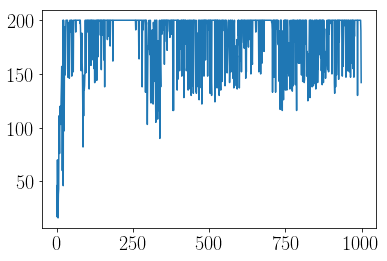

In [13]:
plt.plot(np.arange(len(reward_all)),reward_all)

In [14]:
mean_reward_binned, std_reward_binned, nbins = smooth_rewards(reward_all, bin_length=50)

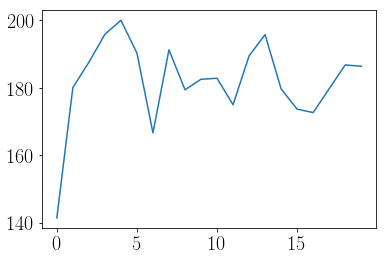

In [15]:
plt.plot(np.arange(nbins), mean_reward_binned)

In [16]:
theta

array([ 4.58701772, -0.10344216, 10.24130242, 19.46087081])

In [17]:
_ = generate_episode(theta, env, 1000, render = True)

Awesome.

To do: 

- Look into reducing gradient variance 
- Implement softmax policy instead of sigmoid. Move code into `TensorFlow`